In [ ]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import albumentations as A
import segmentation_models as sm
from skimage.io import imread, imshow, imread_collection, concatenate_images

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import cv2

Segmentation Models: using `keras` framework.


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
def augment(image,mask):
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Transpose(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50, p=0.5),
    A.RandomGamma(p=0.5)
    ])
  transformed = transform(image=image,mask=mask)
  transformed_image = cv2.cvtColor(transformed['image'], cv2.COLOR_RGB2BGR)
  return transformed_image, transformed['mask']

In [ ]:
# preferred sizes are: 128x128x3 512x512x3
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

LABEL_PATH = '/content/masks_1598x1598/'
IMAGE_PATH = '/content/images_1598x1598/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [ ]:
#labels = next(os.walk(LABEL_PATH))[2]
labels = os.listdir(LABEL_PATH)
test_images = []

for img in os.listdir(IMAGE_PATH):  
  if img not in labels:                #if an image name does not have a label then it is a test image not to be included in the training set
    test_images.append(img)

print('Labels: {} \nTest images: {}'.format(len(labels),len(test_images)))

Labels: 120 
Test images: 59


In [ ]:
#Create training set
augment_count = 3
augmented = True
if augmented:
  length = len(labels) + len(labels) * augment_count
else:
  length = len(labels)
count = 0
X_train = np.zeros((length, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((length, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

for i,label in enumerate(labels):
  img = cv2.imread(IMAGE_PATH + label, cv2.IMREAD_COLOR)#BGR
  mask = cv2.imread(LABEL_PATH + label,cv2.IMREAD_GRAYSCALE)
  if augmented:
    for j in range(augment_count):
      aug_image, aug_mask = augment(img,mask)
      aug_image = cv2.resize(aug_image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)  #resizing image and adding it to the training set
      X_train[len(labels) + i + j + count] = aug_image
      aug_mask = np.expand_dims(cv2.resize(aug_mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA), axis=-1) #since the image is grayscale i added 1 channel at the end to avoid dimension conflict
      Y_train[len(labels) + i + j + count] = aug_mask
    count += augment_count-1

  img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)  #resizing image and adding it to the training set
  X_train[i] = img

  mask = np.expand_dims(cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA), axis=-1) #since the image is grayscale i added 1 channel at the end to avoid dimension conflict
  Y_train[i] = mask

print('X_train: {} \nY_train: {}'.format(X_train.shape,Y_train.shape))
print(count)

X_train: (120, 128, 128, 3) 
Y_train: (120, 128, 128, 1)
0


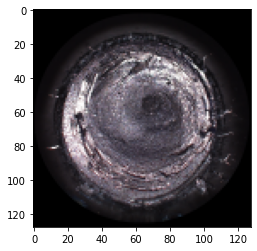

In [ ]:
plt.imshow(X_train[479])
plt.show()

In [ ]:
#Create test set
X_test = np.zeros((len(test_images), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

for i,test in enumerate(test_images):
  img = cv2.imread(IMAGE_PATH + test, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
  X_test[i] = img

print('X_test: {}'.format(X_test.shape))  

X_test: (59, 128, 128, 3)


In [ ]:
#U-Net model with input 128x128x3
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)  #normalizing to 0-1

c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
#print(c4.shape)
u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
#print(u6.shape)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.MeanIoU(num_classes=2)])# sigmoid as act. function and binary crossentropy for loss function because i deal with binary classes
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[sm.metrics.iou_score])
model.summary()
print("The model is defined")

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128, 128, 16) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [ ]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('unet.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=10, epochs=50)

Epoch 1/50
44/44 [==============================] - 99s 2s/step - loss: 0.5255 - iou_score: 0.2840 - val_loss: 0.4456 - val_iou_score: 0.2687
Epoch 2/50
44/44 [==============================] - 70s 2s/step - loss: 0.2654 - iou_score: 0.5230 - val_loss: 0.6691 - val_iou_score: 0.2839
Epoch 3/50
44/44 [==============================] - 69s 2s/step - loss: 0.2687 - iou_score: 0.5641 - val_loss: 0.6788 - val_iou_score: 0.3668
Epoch 4/50
44/44 [==============================] - 69s 2s/step - loss: 0.2238 - iou_score: 0.6223 - val_loss: 0.5335 - val_iou_score: 0.3665
Epoch 5/50
44/44 [==============================] - 69s 2s/step - loss: 0.2058 - iou_score: 0.6526 - val_loss: 0.3283 - val_iou_score: 0.4435
Epoch 6/50
44/44 [==============================] - 69s 2s/step - loss: 0.1608 - iou_score: 0.6883 - val_loss: 0.5581 - val_iou_score: 0.4473
Epoch 7/50
44/44 [==============================] - 69s 2s/step - loss: 0.1484 - iou_score: 0.7355 - val_loss: 0.5708 - val_iou_score: 0.4236
Epoch 

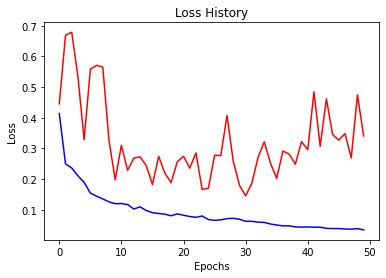

In [ ]:
loss_history = results.history['loss']
val_history = results.history['val_loss']
%matplotlib inline
plt.plot(loss_history,'b')
plt.plot(val_history,'r')
plt.title("Loss History")
plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.show()

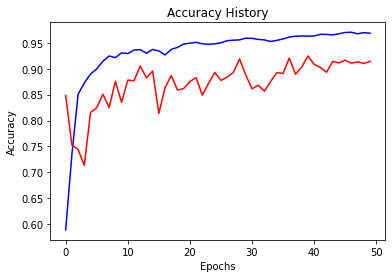

In [ ]:
acc_history = results.history['accuracy']
val_history = results.history['val_accuracy']
%matplotlib inline
plt.plot(acc_history,'b')
plt.plot(val_history,'r')
plt.title("Accuracy History")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

plt.show()

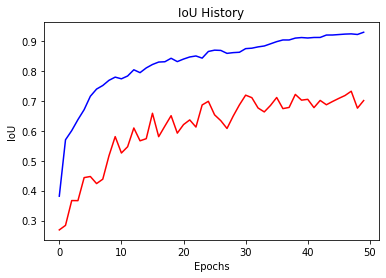

In [ ]:
loss_history = results.history['iou_score']
val_history = results.history['val_iou_score']
%matplotlib inline
plt.plot(loss_history,'b')
plt.plot(val_history,'r')
plt.title("IoU History")
plt.xlabel("Epochs")
plt.ylabel("IoU")

plt.show()

In [ ]:
model.evaluate(X_test,Y_test)

15/15 [==============================] - 17s 1s/step - loss: 0.0613 - iou_score: 0.9075


[0.06129508092999458, 0.9074750542640686]